In [20]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mylasdit/6.las
/kaggle/input/mylasdit/4.las
/kaggle/input/mylasdit/20.las
/kaggle/input/mylasdit/10.las
/kaggle/input/mylasdit/27.las
/kaggle/input/mylasdit/14.las
/kaggle/input/mylasdit/22.las
/kaggle/input/mylasdit/21.las
/kaggle/input/mylasdit/19.las
/kaggle/input/mylasdit/11.las
/kaggle/input/mylasdit/24.las
/kaggle/input/mylasdit/8.las
/kaggle/input/mylasdit/13.las
/kaggle/input/mylasdit/1.las
/kaggle/input/mylasdit/18.las
/kaggle/input/mylasdit/7.las
/kaggle/input/mylasdit/9.las
/kaggle/input/mylasdit/25.las
/kaggle/input/mylasdit/23.las
/kaggle/input/mylasdit/5.las
/kaggle/input/mylasdit/16.las
/kaggle/input/mylasdit/15.las
/kaggle/input/mylasdit/12.las
/kaggle/input/mylasdit/17.las
/kaggle/input/mylasdit/2.las
/kaggle/input/mylasdit/26.las
/kaggle/input/mylasdit/3.las


In [21]:
!pip install laspy --quiet

In [22]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import laspy
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import CosineAnnealingLR
import glob
from tqdm import tqdm
import random
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns


In [23]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed()

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [25]:
class PotholeDataset(Dataset):
    def __init__(self, point_clouds, labels, num_points=1024, transform=None):
        self.point_clouds = point_clouds  # List of point clouds
        self.labels = labels  # List of labels
        self.num_points = num_points
        self.transform = transform
        
    def __len__(self):
        return len(self.point_clouds)
    
    def __getitem__(self, idx):
        point_cloud = self.point_clouds[idx]
        label = self.labels[idx]
        
        # If point cloud has more points than needed, randomly sample
        if point_cloud.shape[0] > self.num_points:
            indices = np.random.choice(point_cloud.shape[0], self.num_points, replace=False)
            point_cloud = point_cloud[indices]
        
        # If point cloud has fewer points than needed, randomly duplicate
        elif point_cloud.shape[0] < self.num_points:
            indices = np.random.choice(point_cloud.shape[0], self.num_points - point_cloud.shape[0], replace=True)
            extra_points = point_cloud[indices]
            point_cloud = np.concatenate([point_cloud, extra_points], axis=0)
        
        # Apply transforms if any
        if self.transform:
            point_cloud = self.transform(point_cloud)
        
        # Convert to tensor
        point_cloud = torch.FloatTensor(point_cloud)
        label = torch.LongTensor([label])[0]
        
        return point_cloud, label


In [26]:
def load_las_files(directory_path, batch_size=16, num_points=1024, val_split=0.2):
    """
    Load multiple .las files from a directory and prepare dataloaders
    FIXED: Handle dimension mismatch errors
    """
    print(f"Loading .las files from {directory_path}")
    las_files = glob.glob(os.path.join(directory_path, "*.las"))
    
    if not las_files:
        raise ValueError(f"No .las files found in {directory_path}")
    
    print(f"Found {len(las_files)} .las files")
    
    all_point_clouds = []
    all_labels = []
    
    for file_path in tqdm(las_files):
        try:
            las = laspy.read(file_path)
            
            # Extract point coordinates and features
            x, y, z = las.x, las.y, las.z
            
            # Get RGB values if available, or use zeros if not
            if hasattr(las, 'red') and hasattr(las, 'green') and hasattr(las, 'blue'):
                r, g, b = las.red, las.green, las.blue
                
                # Normalize RGB values if they're not already in [0,1]
                r_max = np.max(r) if len(r) > 0 else 1
                g_max = np.max(g) if len(g) > 0 else 1
                b_max = np.max(b) if len(b) > 0 else 1
                max_val = max(r_max, g_max, b_max)

                if max_val > 1:
                    r = r / max_val
                    g = g / max_val
                    b = b / max_val
            else:
                r = np.zeros(len(x))
                g = np.zeros(len(x))
                b = np.zeros(len(x))
            
            # Get classifications (labels) - should be 0 or 1 (1 for pothole)
            if hasattr(las, 'classification'):
                classifications = las.classification
            else:
                print(f"No classification field found in {file_path}, using all zeros")
                classifications = np.zeros(len(x), dtype=int)
            
            # Combine features - reshape to ensure compatibility
            all_points = np.column_stack((x, y, z, r, g, b))  # Shape: (N, 6)
            
            # Check if we have points
            if len(all_points) == 0:
                print(f"Warning: No points found in {file_path}")
                continue
            
            # Check if we have pothole points
            pothole_indices = np.where(classifications == 1)[0]
            non_pothole_indices = np.where(classifications == 0)[0]
            
            if len(pothole_indices) == 0:
                print(f"Warning: No pothole points found in {file_path}")
            
            # If there are too few points, we may need to skip some steps
            if len(pothole_indices) < 3 or len(non_pothole_indices) < 3:
                continue
            def sample_region(center_idx, label):
                center_point = all_points[center_idx]
                
                # Calculate distances to all other points - use only XYZ coordinates
                distances = np.sqrt(np.sum((all_points[:, :3] - center_point[:3])**2, axis=1))
                
                # Get indices of nearest points
                nearest_indices = np.argsort(distances)[:num_points]
                region = all_points[nearest_indices]
                
                # Center the region (subtract XYZ of center point from XYZ of all points)
                region = region.copy()  # Create a copy to avoid modifying the original
                region[:, :3] = region[:, :3] - center_point[:3]
                
                return region, label
            
            # Sample pothole regions
            num_pothole_samples = min(len(pothole_indices), 50)
            if num_pothole_samples > 0:
                sample_indices = np.random.choice(pothole_indices, num_pothole_samples, replace=False)
                for idx in sample_indices:
                    region, label = sample_region(idx, 1)
                    all_point_clouds.append(region)
                    all_labels.append(label)
            
            # Sample non-pothole regions
            num_non_pothole_samples = min(len(non_pothole_indices), 50)
            if num_non_pothole_samples > 0:
                sample_indices = np.random.choice(non_pothole_indices, num_non_pothole_samples, replace=False)
                for idx in sample_indices:
                    region, label = sample_region(idx, 0)
                    all_point_clouds.append(region)
                    all_labels.append(label)
            
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
    
    # Check if we have any data
    if len(all_point_clouds) == 0:
        raise ValueError("No valid point cloud regions could be extracted from the .las files")
    train_clouds, val_clouds, train_labels, val_labels = train_test_split(
        all_point_clouds, all_labels, test_size=val_split, random_state=42, stratify=all_labels
    )
    
    print(f"Train set: {len(train_clouds)} samples")
    print(f"Validation set: {len(val_clouds)} samples")
    print(f"Class distribution - Train: {sum(train_labels)}/{len(train_labels)} potholes")
    print(f"Class distribution - Val: {sum(val_labels)}/{len(val_labels)} potholes")
    
    # Create datasets
    train_dataset = PotholeDataset(train_clouds, train_labels, num_points)
    val_dataset = PotholeDataset(val_clouds, val_labels, num_points)
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    
    return train_loader, val_loader


In [27]:
def knn(x, k):
    """
    Compute the indices of k-nearest neighbors for each point.
    x: Tensor of shape (B, F, N)
    Returns indices of shape (B, N, k).
    """
    B, F, N = x.size()
    # Ensure k does not exceed the number of points N.
    k = min(k, N)
    
    # Compute pairwise distances:
    # 1. Compute inner product between points.
    inner = -2 * torch.matmul(x.transpose(2, 1), x)  # (B, N, N)
    # 2. Compute squared norms.
    xx = torch.sum(x ** 2, dim=1, keepdim=True)        # (B, 1, N)
    # 3. Compute pairwise distance matrix.
    pairwise_distance = -xx - inner - xx.transpose(2, 1) # (B, N, N)
    
    # Get the indices of the k smallest distances.
    idx = pairwise_distance.topk(k=k, dim=-1)[1]         # (B, N, k)
    return idx

In [28]:
def get_graph_feature(x, k=20, idx=None):
    """
    Constructs edge features for each point.
    x: Tensor of shape (B, F, N)
    Returns a tensor of shape (B, 2*F, N, k).
    """
    batch_size, num_dims, num_points = x.size()
    if idx is None:
        idx = knn(x, k=k)  # (B, N, k)
        
    # Create a base index so that idx works correctly for batched data.
    device = x.device
    idx_base = torch.arange(0, batch_size, device=device).view(-1, 1, 1) * num_points
    idx = idx + idx_base
    idx = idx.view(-1)
    
    # (B, N, F) -> (B*N, F)
    x = x.transpose(2, 1).contiguous()
    feature = x.view(batch_size * num_points, -1)[idx, :]
    feature = feature.view(batch_size, num_points, -1, num_dims)
    
    # Repeat x to concatenate features.
    x = x.view(batch_size, num_points, 1, num_dims).repeat(1, 1, k, 1)
    feature = torch.cat((feature - x, x), dim=3).permute(0, 3, 1, 2).contiguous()  # (B, 2*F, N, k)
    
    return feature

In [29]:
class DGCNN(nn.Module):
    def __init__(self, input_channels=6, output_channels=2, k=20, emb_dims=1024):
        super(DGCNN, self).__init__()
        self.k = k
        
        # EdgeConv layers
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_channels*2, 64, kernel_size=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.2)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(64*2, 64, kernel_size=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.2)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(64*2, 128, kernel_size=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.2)
        )
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(128*2, 256, kernel_size=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv1d(512, emb_dims, kernel_size=1, bias=False),
            nn.BatchNorm1d(emb_dims),
            nn.LeakyReLU(negative_slope=0.2)
        )
        
        # MLP for classification
        self.linear1 = nn.Linear(emb_dims*2, 512, bias=False)
        self.bn1 = nn.BatchNorm1d(512)
        self.dp1 = nn.Dropout(p=0.5)
        
        self.linear2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.dp2 = nn.Dropout(p=0.5)
        
        self.linear3 = nn.Linear(256, output_channels)

    def forward(self, x):
        batch_size = x.size(0)
        
        # First EdgeConv block
        x = x.transpose(2, 1)  # [B, 6, N]
        edge_feature = get_graph_feature(x, k=self.k)  # [B, 12, N, k]
        x1 = self.conv1(edge_feature)  # [B, 64, N, k]
        x1 = x1.max(dim=-1, keepdim=False)[0]  # [B, 64, N]
        
        # Second EdgeConv block
        edge_feature = get_graph_feature(x1, k=self.k)
        x2 = self.conv2(edge_feature)
        x2 = x2.max(dim=-1, keepdim=False)[0]
        
        # Third EdgeConv block
        edge_feature = get_graph_feature(x2, k=self.k)
        x3 = self.conv3(edge_feature)
        x3 = x3.max(dim=-1, keepdim=False)[0]
        
        # Fourth EdgeConv block
        edge_feature = get_graph_feature(x3, k=self.k)
        x4 = self.conv4(edge_feature)
        x4 = x4.max(dim=-1, keepdim=False)[0]
        
        # Concatenate features
        x = torch.cat((x1, x2, x3, x4), dim=1)  # [B, 512, N]
        
        # Global features
        x = self.conv5(x)  # [B, emb_dims, N]
        x1 = F.adaptive_max_pool1d(x, 1).view(batch_size, -1)  # [B, emb_dims]
        x2 = F.adaptive_avg_pool1d(x, 1).view(batch_size, -1)  # [B, emb_dims]
        x = torch.cat((x1, x2), 1)  # [B, emb_dims*2]
        
        # MLP
        x = F.leaky_relu(self.bn1(self.linear1(x)), negative_slope=0.2)
        x = self.dp1(x)
        x = F.leaky_relu(self.bn2(self.linear2(x)), negative_slope=0.2)
        x = self.dp2(x)
        x = self.linear3(x)
        
        return x

In [30]:

def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    for points, labels in tqdm(dataloader, desc="Training"):
        points, labels = points.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward + backward + optimize
        outputs = model(points)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item() * points.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total

    precision = precision_score(all_labels, all_preds, average='binary', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='binary', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='binary', zero_division=0)
    
    return epoch_loss, epoch_acc, precision, recall, f1
    

In [31]:
def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for points, labels in tqdm(dataloader, desc="Validation"):
            points, labels = points.to(device), labels.to(device)
            
            outputs = model(points)
            loss = criterion(outputs, labels)
            
            # Statistics
            running_loss += loss.item() * points.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    val_loss = running_loss / total
    val_acc = correct / total
    
    # Additional metrics
    precision = precision_score(all_labels, all_preds, average='binary', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='binary', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='binary', zero_division=0)
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    return val_loss, val_acc, precision, recall, f1, cm

In [32]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device, checkpoint_dir='checkpoints'):
    # Create checkpoint directory if it doesn't exist
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    
    best_val_acc = 0.0
    
    # Lists to track metrics
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        
        # Train
        train_loss, train_acc, train_precision, train_recall, train_f1 = train_one_epoch(
            model, train_loader, criterion, optimizer, device
        )
        
        # Validate
        val_loss, val_acc, val_precision, val_recall, val_f1, confusion_mat = validate(
            model, val_loader, criterion, device
        )
        
        # Update learning rate
        scheduler.step()
        
        # Print metrics
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}, Train F1: {train_f1:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        print(f"Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}, Val F1: {val_f1:.4f}")
        
        # Save metrics for plotting
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        # Save checkpoint if best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
            }, "/kaggle/working/best_model.pth")
            print(f"Saved new best model with Val Acc: {val_acc:.4f}")
        
        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=['Non-Pothole', 'Pothole'],
                    yticklabels=['Non-Pothole', 'Pothole'])
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(f'Confusion Matrix - Epoch {epoch+1}')
        plt.tight_layout()
        plt.savefig(os.path.join(checkpoint_dir, f'confusion_matrix_epoch_{epoch+1}.png'))
        plt.close()
    
    # Plot metrics
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs+1), val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs+1), train_accs, label='Train Accuracy')
    plt.plot(range(1, num_epochs+1), val_accs, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(checkpoint_dir, 'training_metrics.png'))
    plt.show()
    
    return model, train_losses, train_accs, val_losses, val_accs


In [33]:
def inference(model, las_file_path, device, num_points=1024):
    """
    Perform inference on a new .las file
    """
    # Load the LAS file
    las = laspy.read(las_file_path)
    
    # Extract point coordinates and features
    x, y, z = las.x, las.y, las.z
    
    if hasattr(las, 'red') and hasattr(las, 'green') and hasattr(las, 'blue'):
        r, g, b = las.red, las.green, las.blue
        # Normalize RGB values if they're not already in [0,1]
        r_max = np.max(r) if len(r) > 0 else 1
        g_max = np.max(g) if len(g) > 0 else 1
        b_max = np.max(b) if len(b) > 0 else 1
        max_val = max(r_max, g_max, b_max)
        
        if max_val > 1:
            r = r / max_val
            g = g / max_val
            b = b / max_val
    else:
        # Use zeros if RGB is not available
        r = np.zeros(len(x))
        g = np.zeros(len(x))
        b = np.zeros(len(x))
    
    # Combine features
    all_points = np.column_stack((x, y, z, r, g, b))  # Shape: (N, 6)
    
    # For each point, we'll create a local region and predict
    predictions = np.zeros(len(all_points), dtype=int)
    sample_size = min(len(all_points), 1000)
    if sample_size > 0:
        sampled_indices = np.random.choice(len(all_points), sample_size, replace=False)
    else:
        return np.array([]), las_file_path  # Return empty array if no points
    
    model.eval()
    with torch.no_grad():
        for idx in tqdm(sampled_indices, desc="Predicting"):
            center_point = all_points[idx]
            
            # Calculate distances to all other points
            distances = np.sqrt(np.sum((all_points[:, :3] - center_point[:3])**2, axis=1))
            
            # Get indices of nearest points
            nearest_indices = np.argsort(distances)[:num_points]
            region = all_points[nearest_indices]
            
            # Center the region
            centered_region = region.copy()
            centered_region[:, :3] = region[:, :3] - center_point[:3]
            
            # Prepare input for model
            inputs = torch.FloatTensor(centered_region).unsqueeze(0).to(device)
            
            # Forward pass
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            
            # If predicted as pothole, set all points in the region as pothole
            if predicted.item() == 1:
                predictions[nearest_indices] = 1
    
    # Create a new LAS file with predictions
    new_las = laspy.LasData(las.header)
    new_las.x = las.x
    new_las.y = las.y
    new_las.z = las.z
    
    if hasattr(las, 'red') and hasattr(las, 'green') and hasattr(las, 'blue'):
        new_las.red = las.red
        new_las.green = las.green
        new_las.blue = las.blue
    
    # Add the classification field
    new_las.classification = predictions
    
    # Save the result
    output_path = r"/kaggle/working/predicted.las"
    new_las.write(output_path)
    
    print(f"Prediction complete. Result saved to {output_path}")
    print(f"Found {np.sum(predictions == 1)} pothole points out of {len(predictions)} total points")
    
    return predictions, output_path



In [34]:
def main():
    # Parameters
    data_dir = "/kaggle/input/mylasdit"  # Update with your actual path
    batch_size = 16
    num_points = 1024
    num_epochs = 50
    learning_rate = 0.001
    k_neighbors = 20
    
    # Load data
    train_loader, val_loader = load_las_files(
        data_dir, 
        batch_size=batch_size, 
        num_points=num_points
    )
    
    # Initialize model
    model = DGCNN(input_channels=6, output_channels=2, k=k_neighbors).to(device)
    
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)
    
    # Train model
    model, train_losses, train_accs, val_losses, val_accs = train_model(
        model, 
        train_loader, 
        val_loader, 
        criterion, 
        optimizer, 
        scheduler, 
        num_epochs, 
        device
    )
    
    # Load best model for inference
    checkpoint = torch.load('/kaggle/working/best_model.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # Example inference on a new file
    # Find a test file that exists in the directory
    test_files = glob.glob(os.path.join(data_dir, "*.las"))
    if test_files:
        test_file = test_files[0]  # Use the first file for testing
        predictions, output_path = inference(model, test_file, device, num_points)
        print(f"Inference complete. Results saved to {output_path}")
        


Loading .las files from /kaggle/input/mylasdit
Found 27 .las files


100%|██████████| 27/27 [00:49<00:00,  1.85s/it]


Train set: 2160 samples
Validation set: 540 samples
Class distribution - Train: 1080/2160 potholes
Class distribution - Val: 270/540 potholes
Epoch 1/50


Validation: 100%|██████████| 34/34 [00:02<00:00, 14.30it/s]


Train Loss: 0.4916, Train Acc: 0.7806
Train Precision: 0.7953, Train Recall: 0.7556, Train F1: 0.7749
Val Loss: 0.4365, Val Acc: 0.8130
Val Precision: 0.7845, Val Recall: 0.8630, Val F1: 0.8219
Saved new best model with Val Acc: 0.8130
Epoch 2/50


Validation: 100%|██████████| 34/34 [00:02<00:00, 14.27it/s]


Train Loss: 0.4541, Train Acc: 0.8000
Train Precision: 0.8074, Train Recall: 0.7880, Train F1: 0.7976
Val Loss: 0.4520, Val Acc: 0.8111
Val Precision: 0.9038, Val Recall: 0.6963, Val F1: 0.7866
Epoch 3/50


Validation: 100%|██████████| 34/34 [00:02<00:00, 14.36it/s]


Train Loss: 0.4062, Train Acc: 0.8324
Train Precision: 0.8330, Train Recall: 0.8315, Train F1: 0.8323
Val Loss: 0.3610, Val Acc: 0.8537
Val Precision: 0.8745, Val Recall: 0.8259, Val F1: 0.8495
Saved new best model with Val Acc: 0.8537
Epoch 4/50


Validation: 100%|██████████| 34/34 [00:02<00:00, 14.28it/s]


Train Loss: 0.4061, Train Acc: 0.8333
Train Precision: 0.8371, Train Recall: 0.8278, Train F1: 0.8324
Val Loss: 0.3825, Val Acc: 0.8537
Val Precision: 0.8328, Val Recall: 0.8852, Val F1: 0.8582
Epoch 5/50


Validation: 100%|██████████| 34/34 [00:02<00:00, 14.37it/s]


Train Loss: 0.3928, Train Acc: 0.8407
Train Precision: 0.8498, Train Recall: 0.8278, Train F1: 0.8386
Val Loss: 0.3533, Val Acc: 0.8574
Val Precision: 0.8845, Val Recall: 0.8222, Val F1: 0.8522
Saved new best model with Val Acc: 0.8574
Epoch 6/50


Validation: 100%|██████████| 34/34 [00:02<00:00, 14.33it/s]


Train Loss: 0.3808, Train Acc: 0.8431
Train Precision: 0.8415, Train Recall: 0.8454, Train F1: 0.8434
Val Loss: 0.3399, Val Acc: 0.8556
Val Precision: 0.9068, Val Recall: 0.7926, Val F1: 0.8458
Epoch 7/50


Validation: 100%|██████████| 34/34 [00:02<00:00, 14.33it/s]


Train Loss: 0.3576, Train Acc: 0.8546
Train Precision: 0.8553, Train Recall: 0.8537, Train F1: 0.8545
Val Loss: 0.3886, Val Acc: 0.8352
Val Precision: 0.9058, Val Recall: 0.7481, Val F1: 0.8195
Epoch 8/50


Validation: 100%|██████████| 34/34 [00:02<00:00, 14.33it/s]


Train Loss: 0.3468, Train Acc: 0.8569
Train Precision: 0.8606, Train Recall: 0.8519, Train F1: 0.8562
Val Loss: 0.4536, Val Acc: 0.7778
Val Precision: 0.7005, Val Recall: 0.9704, Val F1: 0.8137
Epoch 9/50


Validation: 100%|██████████| 34/34 [00:02<00:00, 14.31it/s]


Train Loss: 0.3227, Train Acc: 0.8630
Train Precision: 0.8596, Train Recall: 0.8676, Train F1: 0.8636
Val Loss: 0.3398, Val Acc: 0.8519
Val Precision: 0.8926, Val Recall: 0.8000, Val F1: 0.8438
Epoch 10/50


Validation: 100%|██████████| 34/34 [00:02<00:00, 14.33it/s]


Train Loss: 0.3342, Train Acc: 0.8565
Train Precision: 0.8646, Train Recall: 0.8454, Train F1: 0.8549
Val Loss: 0.3308, Val Acc: 0.8685
Val Precision: 0.8618, Val Recall: 0.8778, Val F1: 0.8697
Saved new best model with Val Acc: 0.8685
Epoch 11/50


Validation: 100%|██████████| 34/34 [00:02<00:00, 14.31it/s]


Train Loss: 0.3271, Train Acc: 0.8611
Train Precision: 0.8558, Train Recall: 0.8685, Train F1: 0.8621
Val Loss: 0.3733, Val Acc: 0.8389
Val Precision: 0.8102, Val Recall: 0.8852, Val F1: 0.8460
Epoch 12/50


Validation: 100%|██████████| 34/34 [00:02<00:00, 14.33it/s]


Train Loss: 0.3078, Train Acc: 0.8718
Train Precision: 0.8694, Train Recall: 0.8750, Train F1: 0.8722
Val Loss: 0.3809, Val Acc: 0.8370
Val Precision: 0.7741, Val Recall: 0.9519, Val F1: 0.8538
Epoch 13/50


Validation: 100%|██████████| 34/34 [00:02<00:00, 14.29it/s]


Train Loss: 0.2826, Train Acc: 0.8838
Train Precision: 0.8842, Train Recall: 0.8833, Train F1: 0.8837
Val Loss: 0.3788, Val Acc: 0.8593
Val Precision: 0.8255, Val Recall: 0.9111, Val F1: 0.8662
Epoch 14/50


Validation: 100%|██████████| 34/34 [00:02<00:00, 14.16it/s]


Train Loss: 0.2801, Train Acc: 0.8736
Train Precision: 0.8665, Train Recall: 0.8833, Train F1: 0.8748
Val Loss: 0.5677, Val Acc: 0.7704
Val Precision: 0.7005, Val Recall: 0.9444, Val F1: 0.8044
Epoch 15/50


Validation: 100%|██████████| 34/34 [00:02<00:00, 14.31it/s]


Train Loss: 0.2466, Train Acc: 0.9005
Train Precision: 0.9001, Train Recall: 0.9009, Train F1: 0.9005
Val Loss: 0.3734, Val Acc: 0.8481
Val Precision: 0.7919, Val Recall: 0.9444, Val F1: 0.8615
Epoch 16/50


Validation: 100%|██████████| 34/34 [00:02<00:00, 14.29it/s]


Train Loss: 0.2451, Train Acc: 0.9056
Train Precision: 0.9071, Train Recall: 0.9037, Train F1: 0.9054
Val Loss: 0.4335, Val Acc: 0.8167
Val Precision: 0.7478, Val Recall: 0.9556, Val F1: 0.8390
Epoch 17/50


Validation: 100%|██████████| 34/34 [00:02<00:00, 14.32it/s]


Train Loss: 0.2218, Train Acc: 0.9102
Train Precision: 0.9117, Train Recall: 0.9083, Train F1: 0.9100
Val Loss: 0.4642, Val Acc: 0.8056
Val Precision: 0.9508, Val Recall: 0.6444, Val F1: 0.7682
Epoch 18/50


Validation: 100%|██████████| 34/34 [00:02<00:00, 14.24it/s]


Train Loss: 0.2037, Train Acc: 0.9208
Train Precision: 0.9228, Train Recall: 0.9185, Train F1: 0.9206
Val Loss: 0.3525, Val Acc: 0.8463
Val Precision: 0.8148, Val Recall: 0.8963, Val F1: 0.8536
Epoch 19/50


Validation: 100%|██████████| 34/34 [00:02<00:00, 14.30it/s]


Train Loss: 0.2180, Train Acc: 0.9171
Train Precision: 0.9122, Train Recall: 0.9231, Train F1: 0.9176
Val Loss: 0.4385, Val Acc: 0.8463
Val Precision: 0.9431, Val Recall: 0.7370, Val F1: 0.8274
Epoch 20/50


Validation: 100%|██████████| 34/34 [00:02<00:00, 14.26it/s]


Train Loss: 0.1662, Train Acc: 0.9343
Train Precision: 0.9351, Train Recall: 0.9333, Train F1: 0.9342
Val Loss: 0.4268, Val Acc: 0.8556
Val Precision: 0.8310, Val Recall: 0.8926, Val F1: 0.8607
Epoch 21/50


Validation: 100%|██████████| 34/34 [00:02<00:00, 14.16it/s]


Train Loss: 0.1666, Train Acc: 0.9366
Train Precision: 0.9402, Train Recall: 0.9324, Train F1: 0.9363
Val Loss: 0.4609, Val Acc: 0.8333
Val Precision: 0.8462, Val Recall: 0.8148, Val F1: 0.8302
Epoch 22/50


Validation: 100%|██████████| 34/34 [00:02<00:00, 14.31it/s]


Train Loss: 0.1431, Train Acc: 0.9412
Train Precision: 0.9384, Train Recall: 0.9444, Train F1: 0.9414
Val Loss: 0.3764, Val Acc: 0.8648
Val Precision: 0.8481, Val Recall: 0.8889, Val F1: 0.8680
Epoch 23/50


Validation: 100%|██████████| 34/34 [00:02<00:00, 14.25it/s]


Train Loss: 0.1485, Train Acc: 0.9412
Train Precision: 0.9491, Train Recall: 0.9324, Train F1: 0.9407
Val Loss: 0.4326, Val Acc: 0.8370
Val Precision: 0.7862, Val Recall: 0.9259, Val F1: 0.8503
Epoch 24/50


Validation: 100%|██████████| 34/34 [00:02<00:00, 14.30it/s]


Train Loss: 0.1139, Train Acc: 0.9560
Train Precision: 0.9539, Train Recall: 0.9583, Train F1: 0.9561
Val Loss: 1.0301, Val Acc: 0.7130
Val Precision: 0.6456, Val Recall: 0.9444, Val F1: 0.7669
Epoch 25/50


Validation: 100%|██████████| 34/34 [00:02<00:00, 14.25it/s]


Train Loss: 0.1339, Train Acc: 0.9486
Train Precision: 0.9425, Train Recall: 0.9556, Train F1: 0.9490
Val Loss: 0.3781, Val Acc: 0.8611
Val Precision: 0.8571, Val Recall: 0.8667, Val F1: 0.8619
Epoch 26/50


Validation: 100%|██████████| 34/34 [00:02<00:00, 14.31it/s]


Train Loss: 0.0778, Train Acc: 0.9718
Train Precision: 0.9713, Train Recall: 0.9722, Train F1: 0.9718
Val Loss: 0.6047, Val Acc: 0.8407
Val Precision: 0.9554, Val Recall: 0.7148, Val F1: 0.8178
Epoch 27/50


Validation: 100%|██████████| 34/34 [00:02<00:00, 14.30it/s]


Train Loss: 0.0887, Train Acc: 0.9676
Train Precision: 0.9667, Train Recall: 0.9685, Train F1: 0.9676
Val Loss: 0.6219, Val Acc: 0.8167
Val Precision: 0.7631, Val Recall: 0.9185, Val F1: 0.8336
Epoch 28/50


Validation: 100%|██████████| 34/34 [00:02<00:00, 14.29it/s]


Train Loss: 0.0850, Train Acc: 0.9699
Train Precision: 0.9712, Train Recall: 0.9685, Train F1: 0.9699
Val Loss: 0.5108, Val Acc: 0.8611
Val Precision: 0.8239, Val Recall: 0.9185, Val F1: 0.8687
Epoch 29/50


Validation: 100%|██████████| 34/34 [00:02<00:00, 14.33it/s]


Train Loss: 0.0849, Train Acc: 0.9681
Train Precision: 0.9642, Train Recall: 0.9722, Train F1: 0.9682
Val Loss: 0.4830, Val Acc: 0.8444
Val Precision: 0.8142, Val Recall: 0.8926, Val F1: 0.8516
Epoch 30/50


Validation: 100%|██████████| 34/34 [00:02<00:00, 14.29it/s]


Train Loss: 0.0762, Train Acc: 0.9755
Train Precision: 0.9759, Train Recall: 0.9750, Train F1: 0.9755
Val Loss: 0.4721, Val Acc: 0.8630
Val Precision: 0.8630, Val Recall: 0.8630, Val F1: 0.8630
Epoch 31/50


Validation: 100%|██████████| 34/34 [00:02<00:00, 14.29it/s]


Train Loss: 0.0547, Train Acc: 0.9815
Train Precision: 0.9779, Train Recall: 0.9852, Train F1: 0.9815
Val Loss: 0.4966, Val Acc: 0.8500
Val Precision: 0.8795, Val Recall: 0.8111, Val F1: 0.8439
Epoch 32/50


Validation: 100%|██████████| 34/34 [00:02<00:00, 14.32it/s]


Train Loss: 0.0512, Train Acc: 0.9796
Train Precision: 0.9805, Train Recall: 0.9787, Train F1: 0.9796
Val Loss: 0.4729, Val Acc: 0.8741
Val Precision: 0.8915, Val Recall: 0.8519, Val F1: 0.8712
Saved new best model with Val Acc: 0.8741
Epoch 33/50


Validation: 100%|██████████| 34/34 [00:02<00:00, 14.32it/s]


Train Loss: 0.0459, Train Acc: 0.9819
Train Precision: 0.9824, Train Recall: 0.9815, Train F1: 0.9819
Val Loss: 0.4798, Val Acc: 0.8593
Val Precision: 0.8619, Val Recall: 0.8556, Val F1: 0.8587
Epoch 34/50


Validation: 100%|██████████| 34/34 [00:02<00:00, 14.20it/s]


Train Loss: 0.0366, Train Acc: 0.9894
Train Precision: 0.9871, Train Recall: 0.9917, Train F1: 0.9894
Val Loss: 0.4595, Val Acc: 0.8741
Val Precision: 0.8659, Val Recall: 0.8852, Val F1: 0.8755
Epoch 35/50


Validation: 100%|██████████| 34/34 [00:02<00:00, 14.30it/s]


Train Loss: 0.0335, Train Acc: 0.9912
Train Precision: 0.9889, Train Recall: 0.9935, Train F1: 0.9912
Val Loss: 0.4834, Val Acc: 0.8741
Val Precision: 0.8713, Val Recall: 0.8778, Val F1: 0.8745
Epoch 36/50


Validation: 100%|██████████| 34/34 [00:02<00:00, 14.28it/s]


Train Loss: 0.0297, Train Acc: 0.9907
Train Precision: 0.9907, Train Recall: 0.9907, Train F1: 0.9907
Val Loss: 0.5444, Val Acc: 0.8648
Val Precision: 0.9191, Val Recall: 0.8000, Val F1: 0.8554
Epoch 37/50


Validation: 100%|██████████| 34/34 [00:02<00:00, 14.10it/s]


Train Loss: 0.0293, Train Acc: 0.9894
Train Precision: 0.9880, Train Recall: 0.9907, Train F1: 0.9894
Val Loss: 0.5596, Val Acc: 0.8556
Val Precision: 0.8357, Val Recall: 0.8852, Val F1: 0.8597
Epoch 38/50


Validation: 100%|██████████| 34/34 [00:02<00:00, 14.26it/s]


Train Loss: 0.0444, Train Acc: 0.9852
Train Precision: 0.9861, Train Recall: 0.9843, Train F1: 0.9852
Val Loss: 0.4607, Val Acc: 0.8741
Val Precision: 0.8885, Val Recall: 0.8556, Val F1: 0.8717
Epoch 39/50


Validation: 100%|██████████| 34/34 [00:02<00:00, 14.31it/s]


Train Loss: 0.0357, Train Acc: 0.9884
Train Precision: 0.9862, Train Recall: 0.9907, Train F1: 0.9885
Val Loss: 0.5137, Val Acc: 0.8759
Val Precision: 0.8949, Val Recall: 0.8519, Val F1: 0.8729
Saved new best model with Val Acc: 0.8759
Epoch 40/50


Validation: 100%|██████████| 34/34 [00:02<00:00, 14.30it/s]


Train Loss: 0.0272, Train Acc: 0.9898
Train Precision: 0.9871, Train Recall: 0.9926, Train F1: 0.9898
Val Loss: 0.4876, Val Acc: 0.8667
Val Precision: 0.8561, Val Recall: 0.8815, Val F1: 0.8686
Epoch 41/50


Validation: 100%|██████████| 34/34 [00:02<00:00, 14.25it/s]


Train Loss: 0.0217, Train Acc: 0.9917
Train Precision: 0.9890, Train Recall: 0.9944, Train F1: 0.9917
Val Loss: 0.4848, Val Acc: 0.8704
Val Precision: 0.8623, Val Recall: 0.8815, Val F1: 0.8718
Epoch 42/50


Validation: 100%|██████████| 34/34 [00:02<00:00, 14.28it/s]


Train Loss: 0.0193, Train Acc: 0.9940
Train Precision: 0.9954, Train Recall: 0.9926, Train F1: 0.9940
Val Loss: 0.5008, Val Acc: 0.8648
Val Precision: 0.8689, Val Recall: 0.8593, Val F1: 0.8641
Epoch 43/50


Validation: 100%|██████████| 34/34 [00:02<00:00, 14.29it/s]


Train Loss: 0.0158, Train Acc: 0.9949
Train Precision: 0.9954, Train Recall: 0.9944, Train F1: 0.9949
Val Loss: 0.4894, Val Acc: 0.8667
Val Precision: 0.8561, Val Recall: 0.8815, Val F1: 0.8686
Epoch 44/50


Validation: 100%|██████████| 34/34 [00:02<00:00, 14.28it/s]


Train Loss: 0.0153, Train Acc: 0.9940
Train Precision: 0.9954, Train Recall: 0.9926, Train F1: 0.9940
Val Loss: 0.5295, Val Acc: 0.8722
Val Precision: 0.8911, Val Recall: 0.8481, Val F1: 0.8691
Epoch 45/50


Validation: 100%|██████████| 34/34 [00:02<00:00, 14.33it/s]


Train Loss: 0.0200, Train Acc: 0.9944
Train Precision: 0.9963, Train Recall: 0.9926, Train F1: 0.9944
Val Loss: 0.5177, Val Acc: 0.8593
Val Precision: 0.8489, Val Recall: 0.8741, Val F1: 0.8613
Epoch 46/50


Validation: 100%|██████████| 34/34 [00:02<00:00, 14.33it/s]


Train Loss: 0.0173, Train Acc: 0.9963
Train Precision: 0.9954, Train Recall: 0.9972, Train F1: 0.9963
Val Loss: 0.4981, Val Acc: 0.8704
Val Precision: 0.8676, Val Recall: 0.8741, Val F1: 0.8708
Epoch 47/50


Validation: 100%|██████████| 34/34 [00:02<00:00, 14.29it/s]


Train Loss: 0.0145, Train Acc: 0.9972
Train Precision: 0.9954, Train Recall: 0.9991, Train F1: 0.9972
Val Loss: 0.5313, Val Acc: 0.8630
Val Precision: 0.8984, Val Recall: 0.8185, Val F1: 0.8566
Epoch 48/50


Validation: 100%|██████████| 34/34 [00:02<00:00, 14.26it/s]


Train Loss: 0.0208, Train Acc: 0.9931
Train Precision: 0.9917, Train Recall: 0.9944, Train F1: 0.9931
Val Loss: 0.5135, Val Acc: 0.8685
Val Precision: 0.8872, Val Recall: 0.8444, Val F1: 0.8653
Epoch 49/50


Validation: 100%|██████████| 34/34 [00:02<00:00, 14.25it/s]


Train Loss: 0.0116, Train Acc: 0.9954
Train Precision: 0.9991, Train Recall: 0.9917, Train F1: 0.9954
Val Loss: 0.5040, Val Acc: 0.8648
Val Precision: 0.8863, Val Recall: 0.8370, Val F1: 0.8610
Epoch 50/50


Validation: 100%|██████████| 34/34 [00:02<00:00, 14.25it/s]


Train Loss: 0.0117, Train Acc: 0.9949
Train Precision: 0.9963, Train Recall: 0.9935, Train F1: 0.9949
Val Loss: 0.5112, Val Acc: 0.8722
Val Precision: 0.8911, Val Recall: 0.8481, Val F1: 0.8691


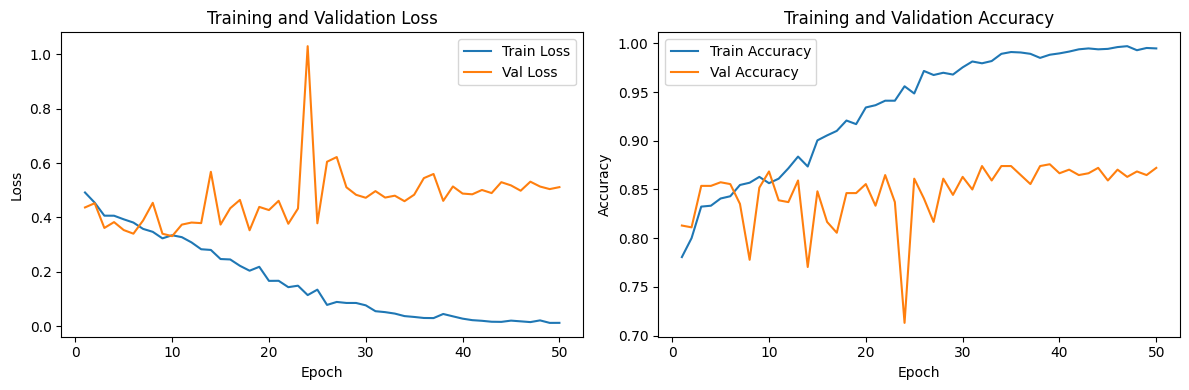

/tmp/ipykernel_31/2819147627.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/kaggle/working/best_model.pth')
Predicting: 100%|██████████| 1000

Prediction complete. Result saved to /kaggle/working/predicted.las
Found 111283 pothole points out of 363399 total points
Inference complete. Results saved to /kaggle/working/predicted.las


In [35]:
if __name__ == "__main__":
    main()